In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from IPython import embed
from scipy.ndimage import rotate
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
from scipy.ndimage import label

In [31]:
def performance(img_id, min_elevation, max_prominence, rel=None):
    # Load results and GT mask
    # df = pd.read_csv(f'results/{img_id}.txt', delimiter=',')
    df = pd.read_csv(f'results/results_fullsize/{img_id}.txt', delimiter=',')
    df[['x', 'y']] = df[['x', 'y']].astype(int)
    # masks_uint8 = cv2.imread(f'masks/{img_id}_masks.png', cv2.IMREAD_UNCHANGED)
    masks_uint8 = cv2.imread(f'data/images_fullsize/masks/{img_id}_masks.png', cv2.IMREAD_UNCHANGED)
    masks = masks_uint8/255
    
    # filter low elevation
    filtered_df = df[df['elevation'] >= int(min_elevation)]
    filtered_df = filtered_df[filtered_df['prominence'] >= int(max_prominence)]

    if rel is not None:
        filtered_df = filtered_df[(filtered_df['elevation'] <= 800) | ((filtered_df['elevation'] > 800) & (filtered_df['prominence'] >= filtered_df['elevation'] * rel))]

    
    df = filtered_df.copy()
    
    # Get false positive by lopping through all peaks found by prominence and check the corresponding mask value
    
    fp = len(df) # initiate false positives as all points
    fp_list = []
    df['correct'] = 0
    
    for index, row in df.iterrows():
        gt_value = masks[int(row['y']), int(row['x'])]
        #tp += gt_value # add if inside mask
        fp = fp - gt_value # subtract value 1 if inside mask 
        if gt_value == 1:
           
            df.at[index, 'correct'] = 1
        if gt_value == 0:
            fp_list.append([int(row['x']), int(row['y'])])
            df.at[index, 'correct'] = 0

    # Get mask count
    ann_map, num_features = label(masks)
    
    tp = 0  # True positives are masks that have one or more peaks found by prominence
    fn = 0  # False negatives are masks that have no peak in them
    
    small_gt_masks = 0
    multi_peaks = 0 # Count masks that have more than 1 peaks in them
    for value in range(1,num_features+1):
        coords = np.argwhere(ann_map == value)
        # if len(coords)<8:
        #     small_gt_masks = small_gt_masks + 1
        #     embed()
        #     # plt.plot(coords[0][0], coords[0][1], markersize=6)
        #     continue
    
        # Convert the array to a DataFrame for easier comparison
        coords_df = pd.DataFrame(coords, columns=['y', 'x'])
        # Merge to find matching coordinates
        merged_df = pd.merge(df, coords_df, on=['x', 'y'], how='inner')
        # merged_df = pd.merge(df, coords_df, on=['y', 'x'], how='inner')

        if len(merged_df)<1:
            fn = fn + 1
            masks[coords[:, 0], coords[:, 1]] = 2
        elif len(merged_df)==1:
            tp = tp + 1
            multi_peaks = multi_peaks + 1
            masks[coords[:, 0], coords[:, 1]] = 1
        else:
            tp = tp + 1
            masks[coords[:, 0], coords[:, 1]] = 1
            
    precision = tp / (tp + fp)
    recall = tp / (tp+fn)  
    
    
    # Create a custom colormap
    colors = ['black', 'yellow', 'red']
    cmap = ListedColormap(colors)
    
    fig1 = plt.figure()
    plt.imshow(masks, cmap=cmap, interpolation='nearest')
    for row in fp_list:
        plt.plot(row[0], row[1], marker='.', markersize=1, c='b')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig(f'plots/{img_id}_eval.png')

    print(f'precision proxy: {precision*100}\nrecall: {recall*100}')
    print(f'tp: {int(tp)}/{value-small_gt_masks}')
    print(f'fn: {int(fn)}/{value-small_gt_masks}')
    print(f'fp: {int(fp)}')
    

    fig2 = plt.figure()
    true_df = df[df['correct'] == 1]
    false_df = df[df['correct'] == 0]
    for index, row in true_df.iterrows():
        plt.plot(row['elevation'], row['prominence'], marker='.', markersize=4, c='r')
    for index, row in false_df.iterrows():
        plt.plot(row['elevation'], row['prominence'], marker='.', markersize=4, c='b')
    
    plt.xlabel('elevation')
    plt.ylabel('prominence')
    plt.grid()
    plt.show()

In [32]:
def plot_res(image_id, elevation_min, max_prominence):
    # img = cv2.imread(f'images_georef/{image_id}_georef.tif', cv2.IMREAD_UNCHANGED)
    img = cv2.imread(f'data/images_fullsize/images/{image_id}.tif', cv2.IMREAD_UNCHANGED)
    # masks = cv2.imread(f'masks/{image_id}_masks.png', cv2.IMREAD_UNCHANGED)
    masks = cv2.imread(f'data/images_fullsize/masks/{image_id}_masks.png', cv2.IMREAD_UNCHANGED)

    
    # Load results
    # file_path = f'results/{image_id}.txt'
    file_path = f'results/results_fullsize/{image_id}.txt'
    
    # Read the text file into a DataFrame
    df = pd.read_csv(file_path, delimiter=',')
    filtered_df = df[df['elevation'] >= int(elevation_min)]
    filtered_df = filtered_df[filtered_df['prominence'] >= int(max_prominence)]
    
    df = filtered_df
    
    # make plots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), layout="constrained")
    max_val = img.max() * 1
    im1 = axes[0].imshow(img, cmap='gray', vmax = max_val)
    
    for index, row in df.iterrows():
        axes[0].plot(row['x'], row['y'], marker='.', markersize=1, c='r')
    im2 = axes[1].imshow(masks, cmap='gray', interpolation='nearest')
    im3 = axes[2].imshow(img, cmap='gray', vmax = max_val)
    
    fig.colorbar(im3, ax=axes.ravel().tolist(),location='right')


    plt.show()

In [41]:
def count_min_under_threshold(img_id, limit):
    # Load GT mask and original image
    img = cv2.imread(f'data/images_fullsize/images/{img_id}.tif', cv2.IMREAD_UNCHANGED)
    img = np.array(img)
    print(f'min img: {img.min()}')
    masks_uint8 = cv2.imread(f'data/images_fullsize/masks/{img_id}_masks.png', cv2.IMREAD_UNCHANGED)
    masks = masks_uint8/255

    # Get mask count
    ann_map, num_features = label(masks)
    max_values = []
    for value in range(1,num_features+1):
        coords = np.argwhere(ann_map == value)
        # spot = img[coords[:, 1], coords[:, 0]]
        spot = img[coords[:, 0], coords[:, 1]]
        spot_max = spot.max()
            
        if len(coords)>2:
            max_values.append(spot_max)
            
        else:
            print(f'spot of len {len(coords)} and peak {spot_max} exluded')
     
    count = sum(1 for x in max_values if x < limit)
    print(f'{count} of {len(max_values)} peaks below limit')
    print(f' {count*100/len(max_values)} % are below {limit}' )
    plt.hist(max_values, bins=3000, range=(0,3000) ,edgecolor='black')
    plt.xlabel('peak pixel value')
    plt.ylabel('count')
    plt.title(f'{img_id}')
    print(f'The lowest peak is: {np.array(max_values).min()}')



In [42]:
def plot_min_under_threshold(img_id, limit):
    # Load GT mask and original image
    img = cv2.imread(f'data/images_fullsize/images/{img_id}.tif', cv2.IMREAD_UNCHANGED)
    img = np.array(img)
    print(f'min img: {img.min()}')
    masks_uint8 = cv2.imread(f'data/images_fullsize/masks/{img_id}_masks.png', cv2.IMREAD_UNCHANGED)
    masks = masks_uint8/255

    # Get mask count
    ann_map, num_features = label(masks)
    max_values = []
    for value in range(1,num_features+1):
        coords = np.argwhere(ann_map == value)
        if len(coords)>4:
            spot = img[coords[:, 0], coords[:, 1]]
            spot_max = spot.max()
            if spot_max < limit:
                xmin, xmax = coords[:, 1].min(), coords[:, 1].max()
                ymin, ymax = coords[:, 0].min(), coords[:, 0].max()
    
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10) , layout="constrained")
                buf = 40  # Example buffer value
                image_size = 2048  # Example image size
    
                if (xmin > buf and xmax < image_size - buf and
                    ymin > buf and ymax < image_size - buf):
    
                    im1 = axes[0].imshow(img[ymin-buf:ymax+buf, xmin-buf:xmax+buf], cmap='gray')
                    
                    axes[1].imshow(img[ymin-buf:ymax+buf, xmin-buf:xmax+buf], cmap='gray')
                    # Adjust coordinates for the cropped image
                    adjusted_coords = coords - [ymin-buf, xmin-buf]
    
                    # Plot the adjusted coordinates
                    # im2 = axes[1].plot(adjusted_coords[:, 1], adjusted_coords[:, 0], 'r.')
                    im2 = axes[1].scatter(adjusted_coords[:, 1], adjusted_coords[:, 0], c='r', s=5)
                    fig.colorbar(im1, ax=axes[1],location='right')
                # plt.tight_layout()
                plt.show()
            max_values.append(spot_max)
            
        else:
            print(f'spot of len {len(coords)} and peak {spot_max} exluded')
     
    count = sum(1 for x in max_values if x < limit)
    print(f'{count} of {len(max_values)} peaks below limit')
    print(f' {count*100/len(max_values)} % are below {limit}' )

    print(f'The lowest peak is: {np.array(max_values).min()}')



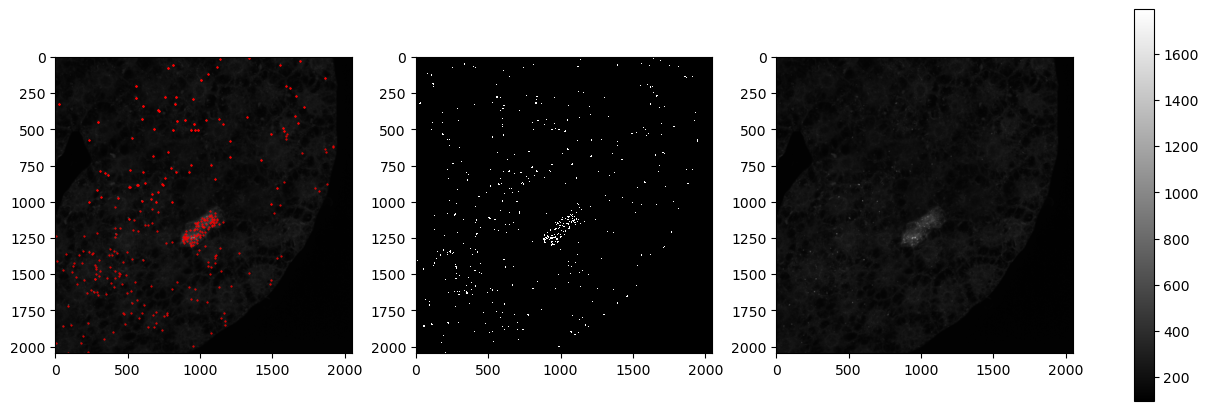

precision proxy: 82.08469055374593
recall: 51.533742331288344
tp: 252/489
fn: 237/489
fp: 55


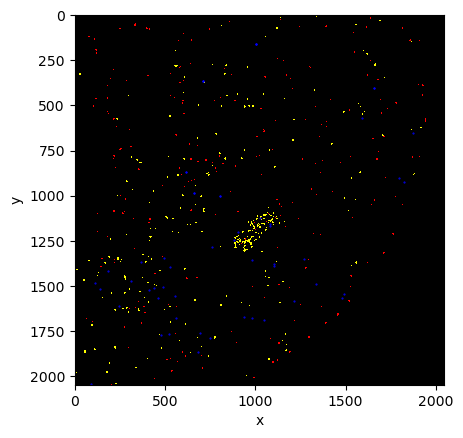

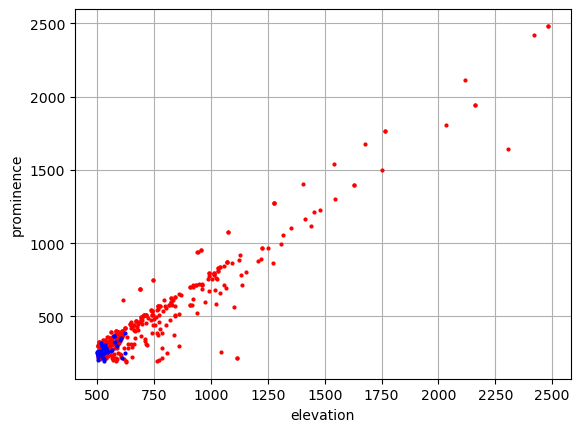

In [13]:
image_id = 'MF_MaxIP_3ch_2_000_230623_544_84_F_XY4'
elevation_min = 500
max_prominence = 190

plot_res(image_id, elevation_min, max_prominence)
performance(image_id, elevation_min, max_prominence)

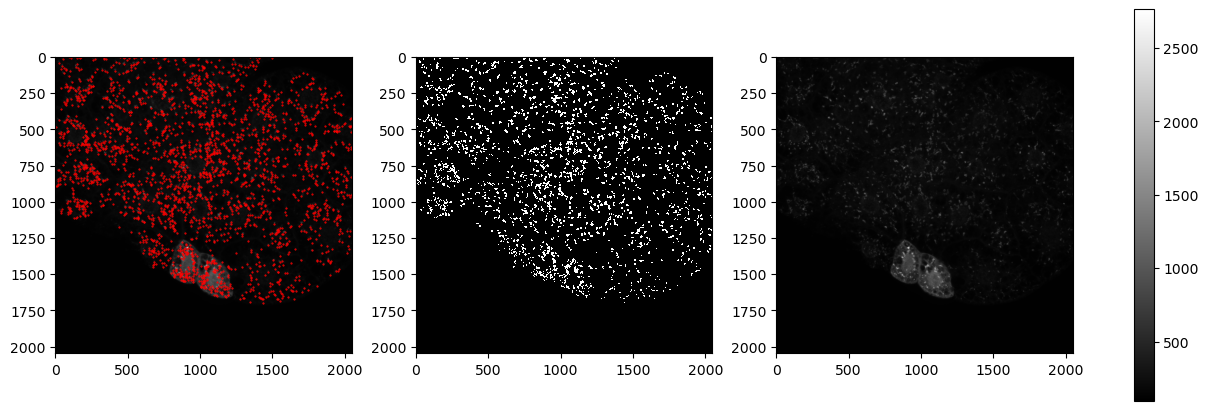

precision proxy: 82.71150814503414
recall: 94.36450839328538
tp: 1574/1668
fn: 94/1668
fp: 329


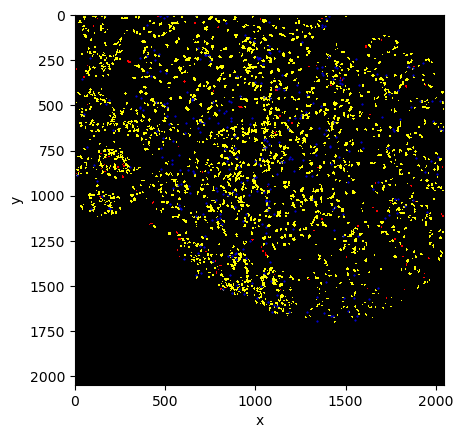

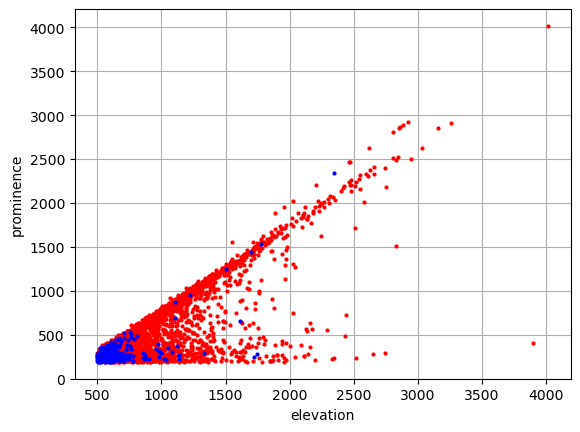

In [12]:
image_id = 'MF_MaxIP_3ch_2_000_230623_544_84_S4h_XY2'
elevation_min = 500
max_prominence = 190

plot_res(image_id, elevation_min, max_prominence)
performance(image_id, elevation_min, max_prominence)

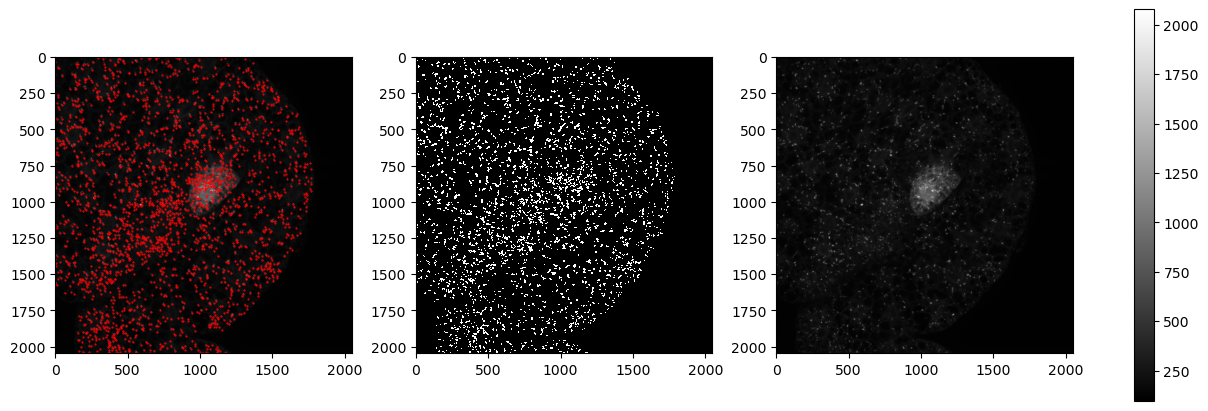

precision proxy: 97.20580333154219
recall: 78.21011673151752
tp: 1809/2313
fn: 504/2313
fp: 52


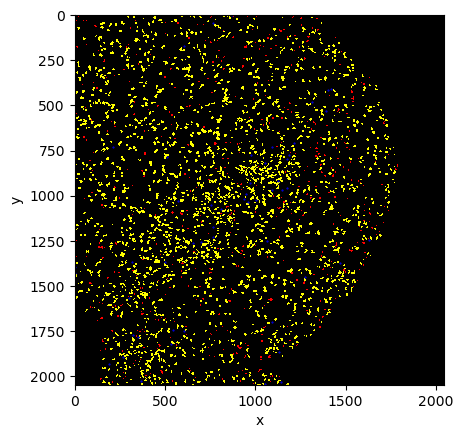

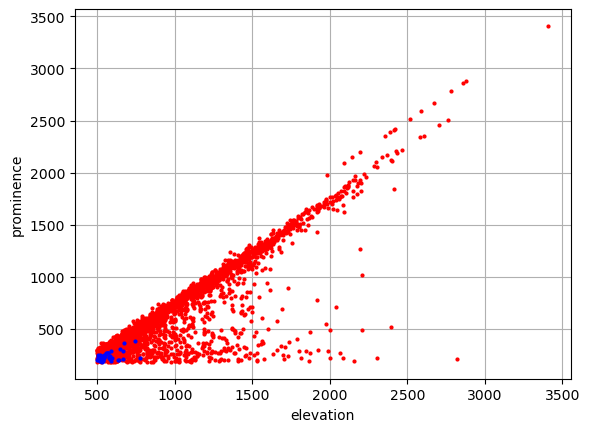

In [14]:
image_id = 'MF_MaxIP_3ch_2_000_230623_544_84_R1h_XY5'
elevation_min = 500
max_prominence = 180

plot_res(image_id, elevation_min, max_prominence)
performance(image_id, elevation_min, max_prominence)

min img: 97
268 of 489 peaks below limit
 54.805725971370144 % are below 400
The lowest peak is: 213


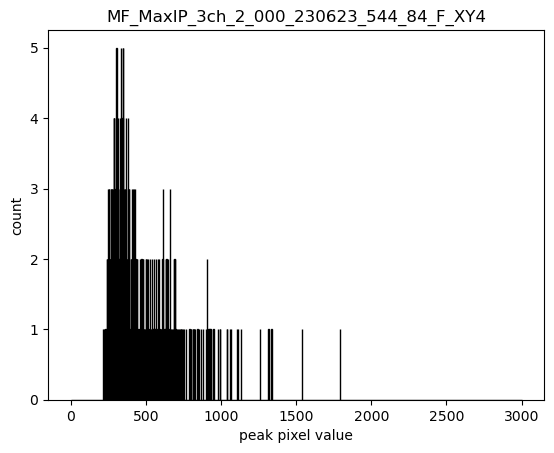

In [21]:
img_id = 'MF_MaxIP_3ch_2_000_230623_544_84_F_XY4'
count_limit = 400
count_min_under_threshold(img_id, count_limit)


min img: 96
spot of len 1 and peak 269 exluded
202 of 1667 peaks below limit
 12.11757648470306 % are below 400
The lowest peak is: 258


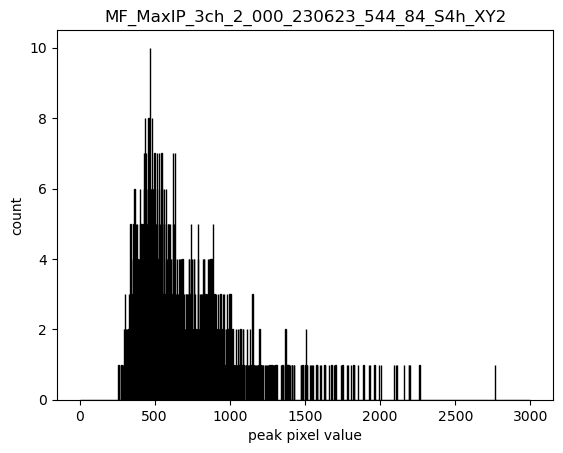

In [26]:
img_id = 'MF_MaxIP_3ch_2_000_230623_544_84_S4h_XY2'
count_limit = 400
count_min_under_threshold(img_id, count_limit)

min img: 96
spot of len 1 and peak 269 exluded
202 of 1667 peaks below limit
 12.11757648470306 % are below 400
The lowest peak is: 258


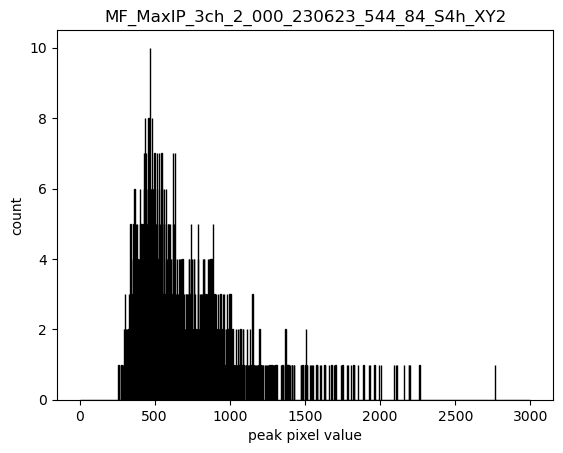

In [27]:
img_id = 'MF_MaxIP_3ch_2_000_230623_544_84_S4h_XY2'
count_limit = 400
count_min_under_threshold(img_id, count_limit)

min img: 97


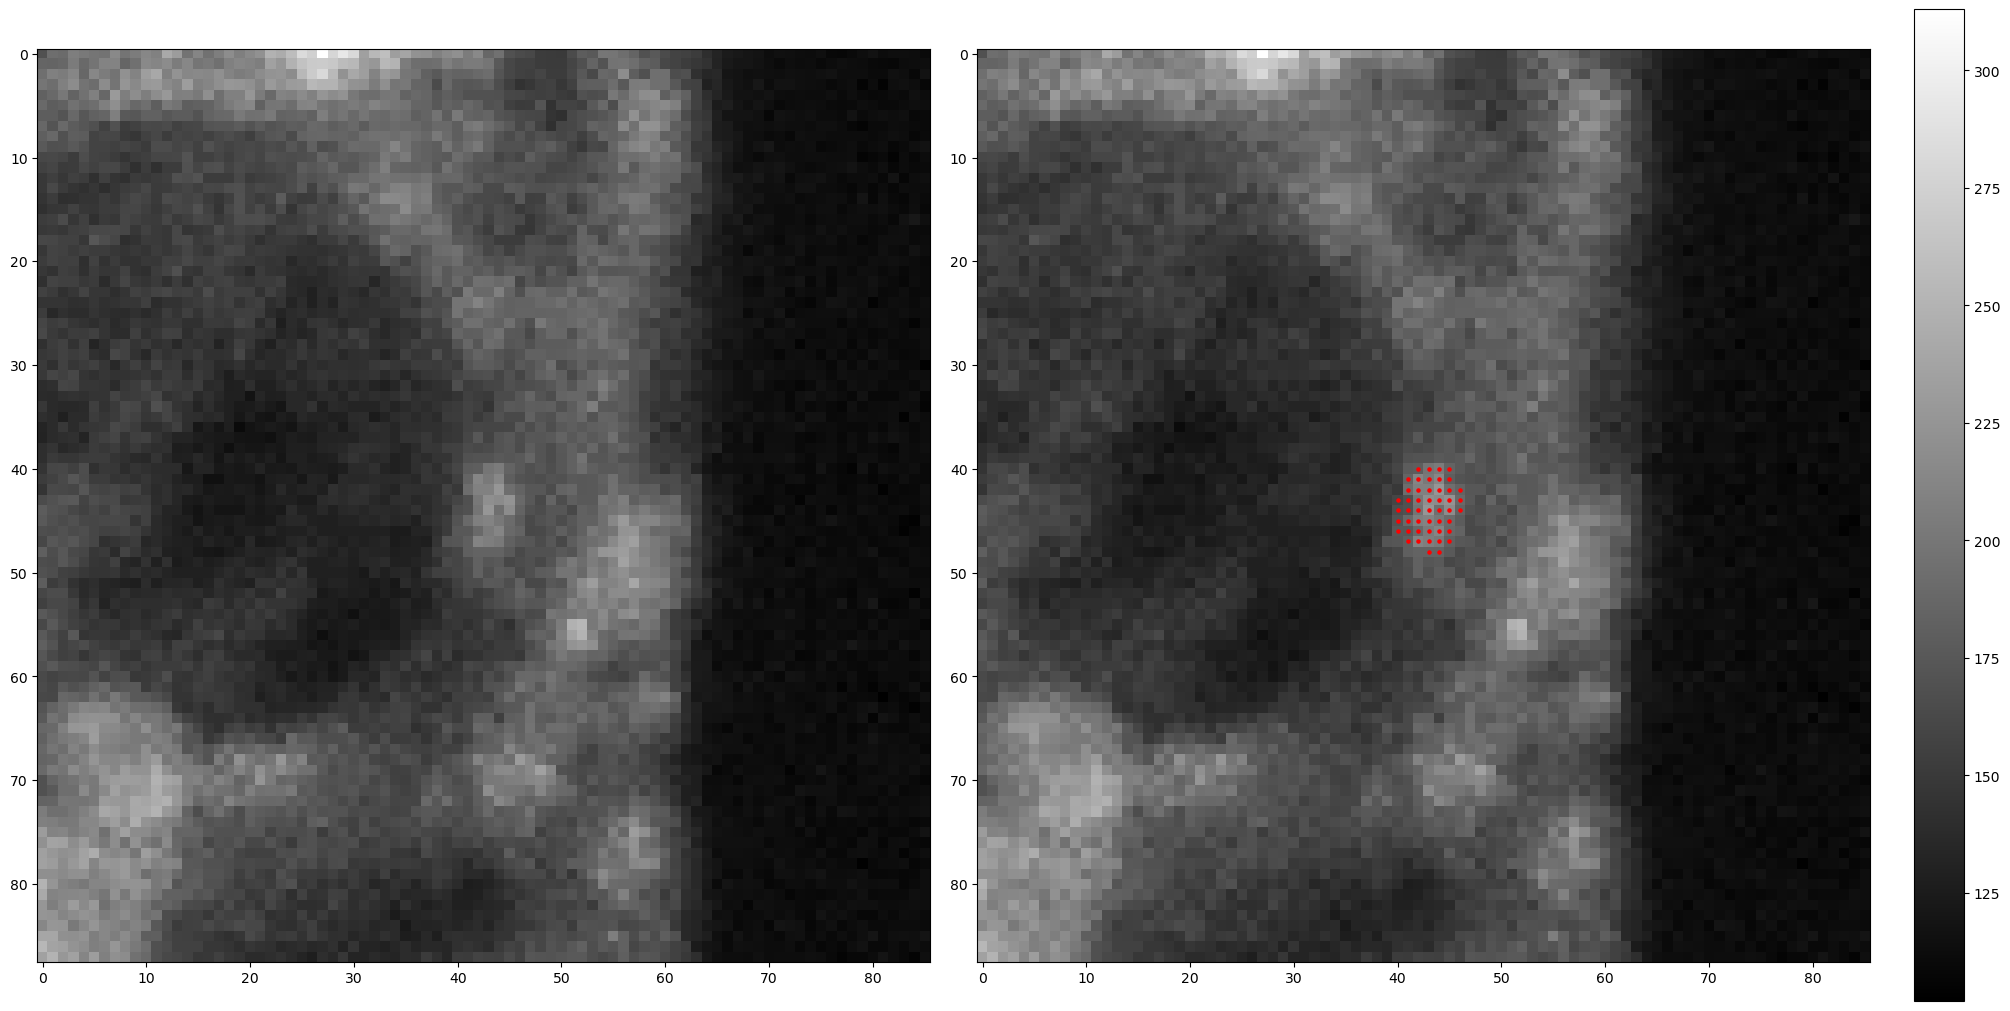

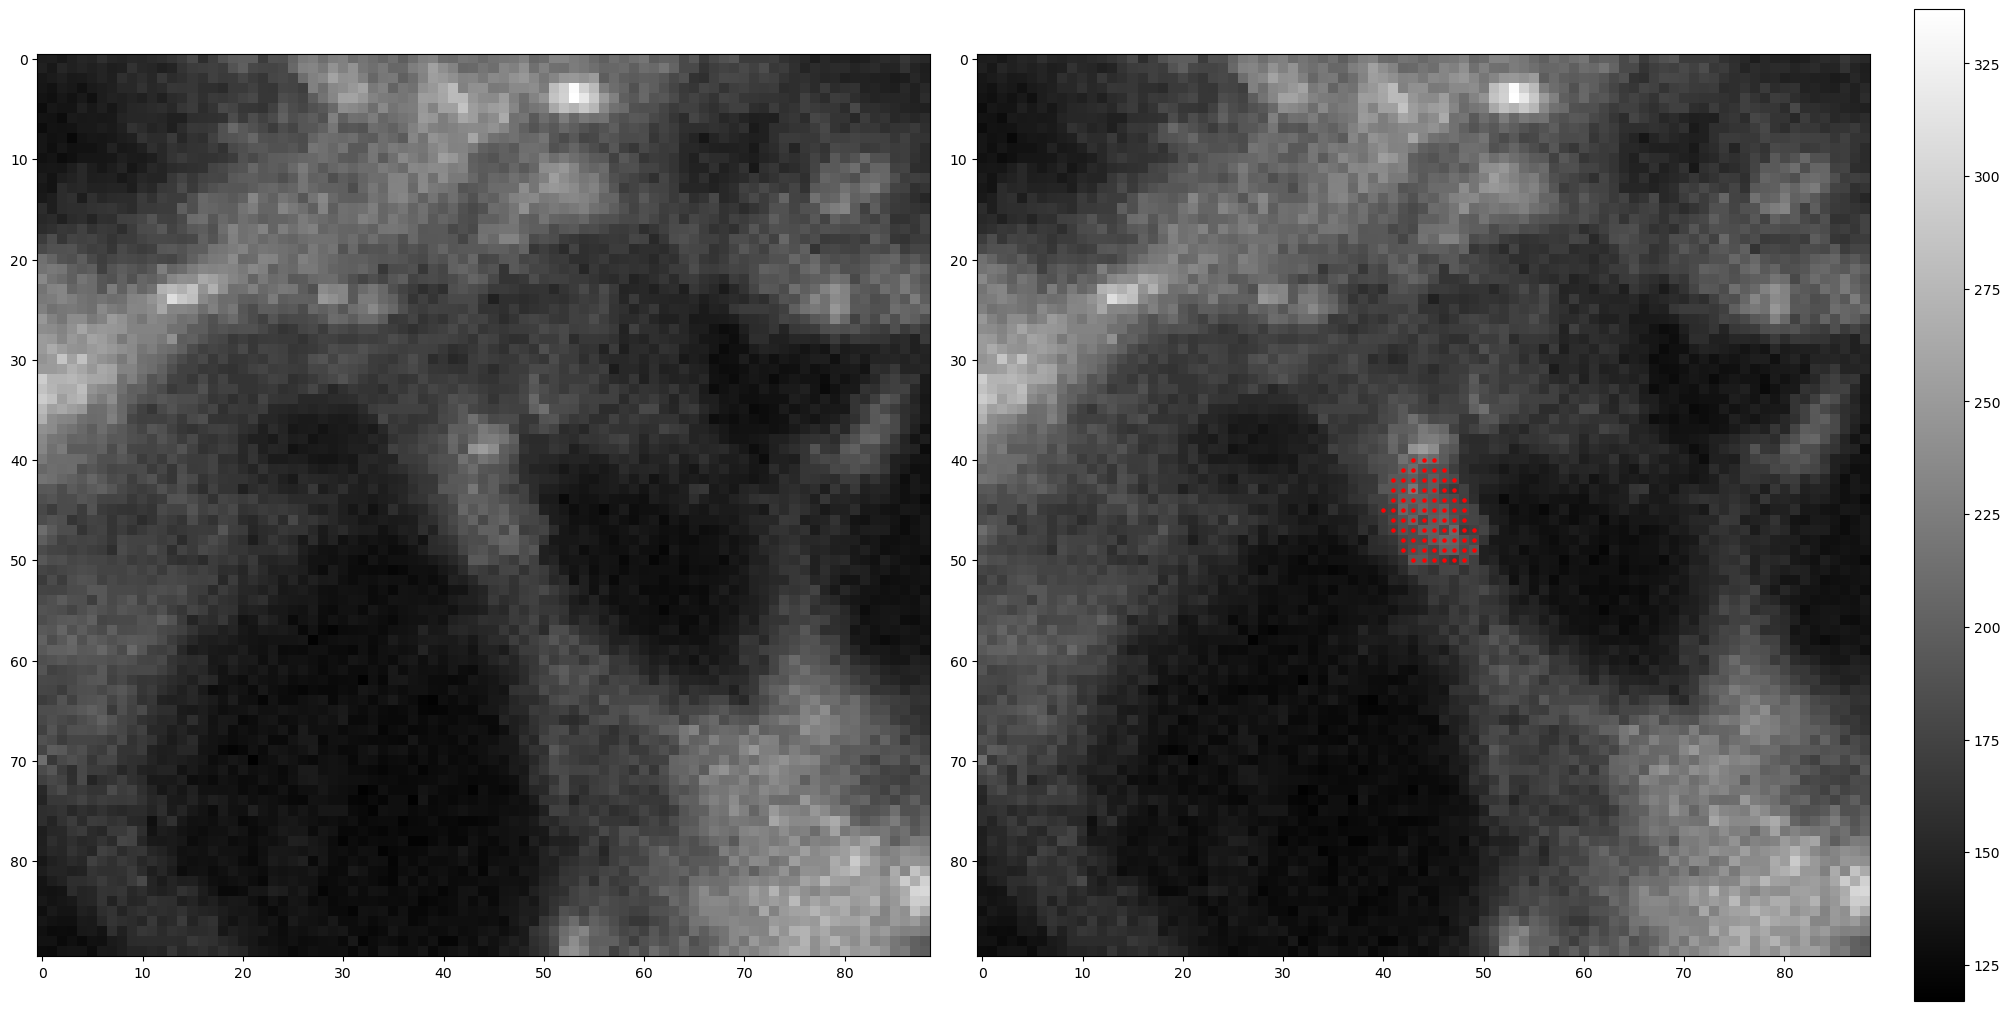

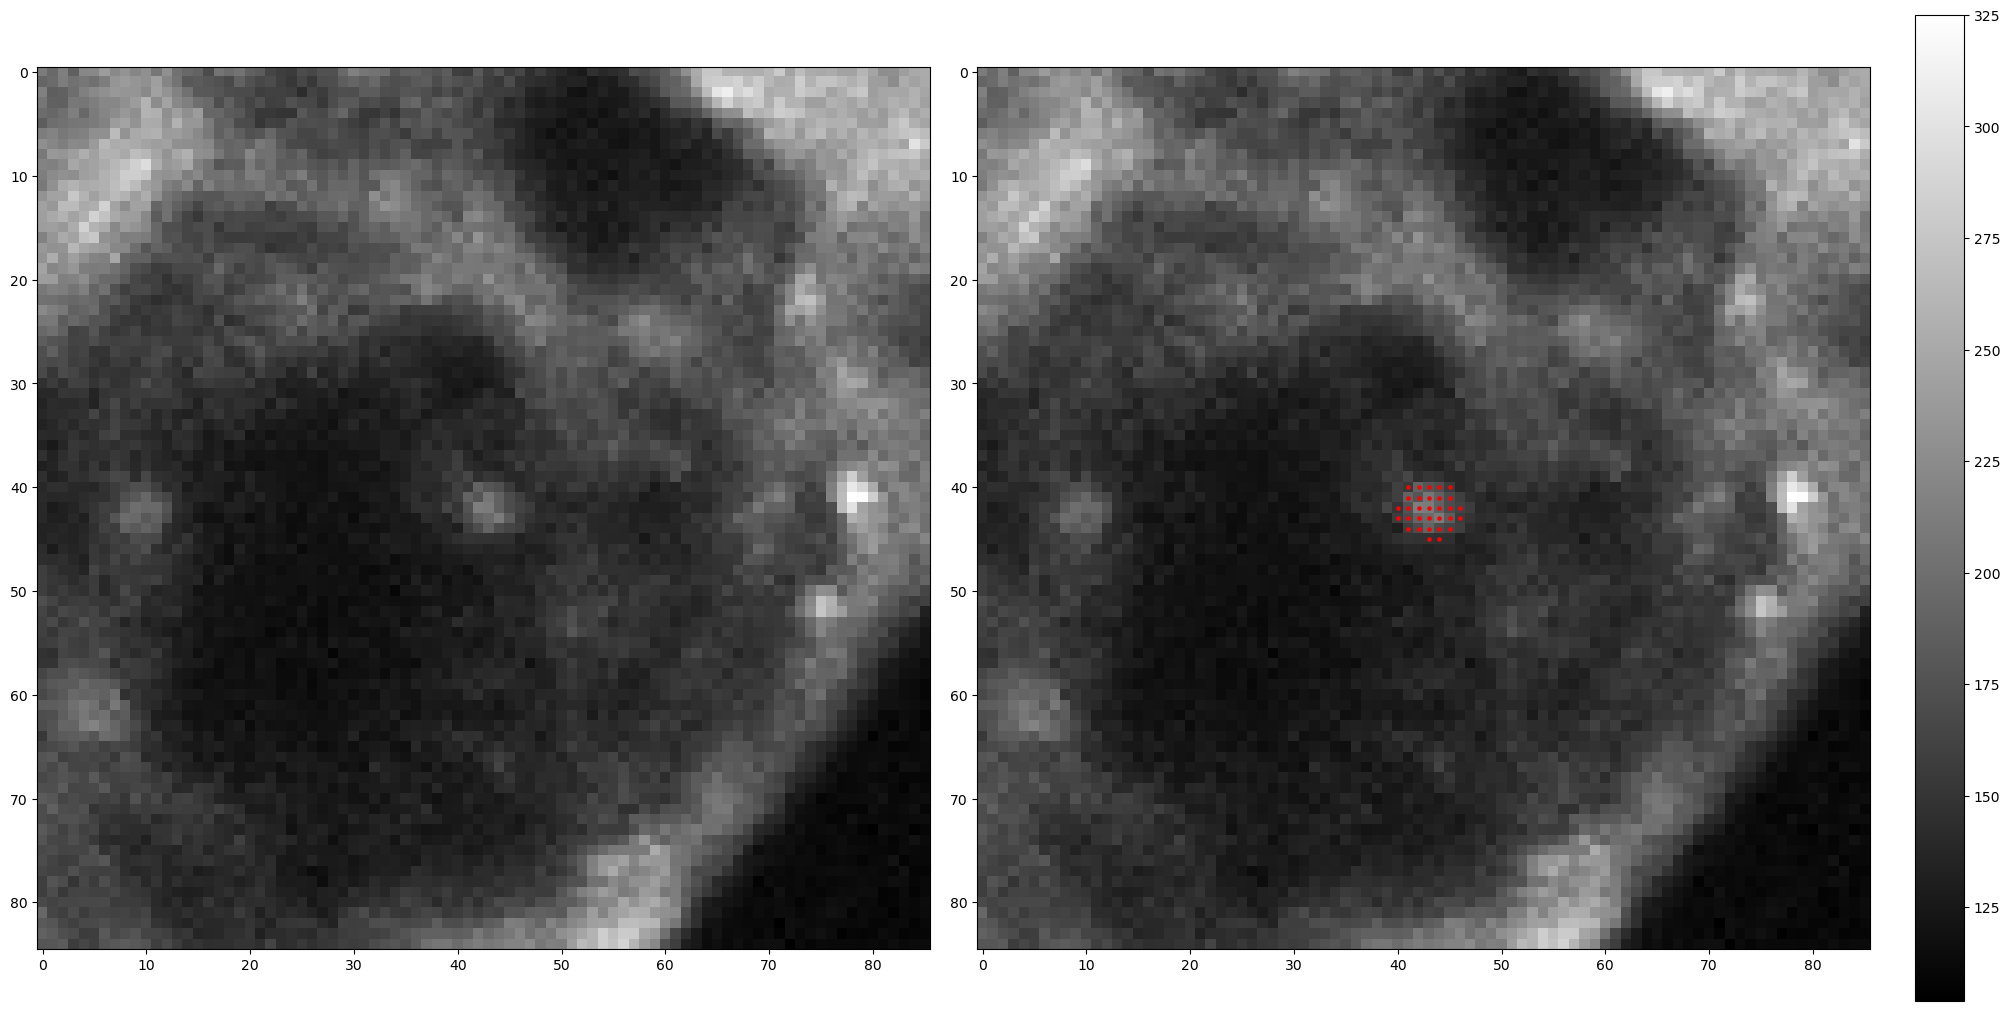

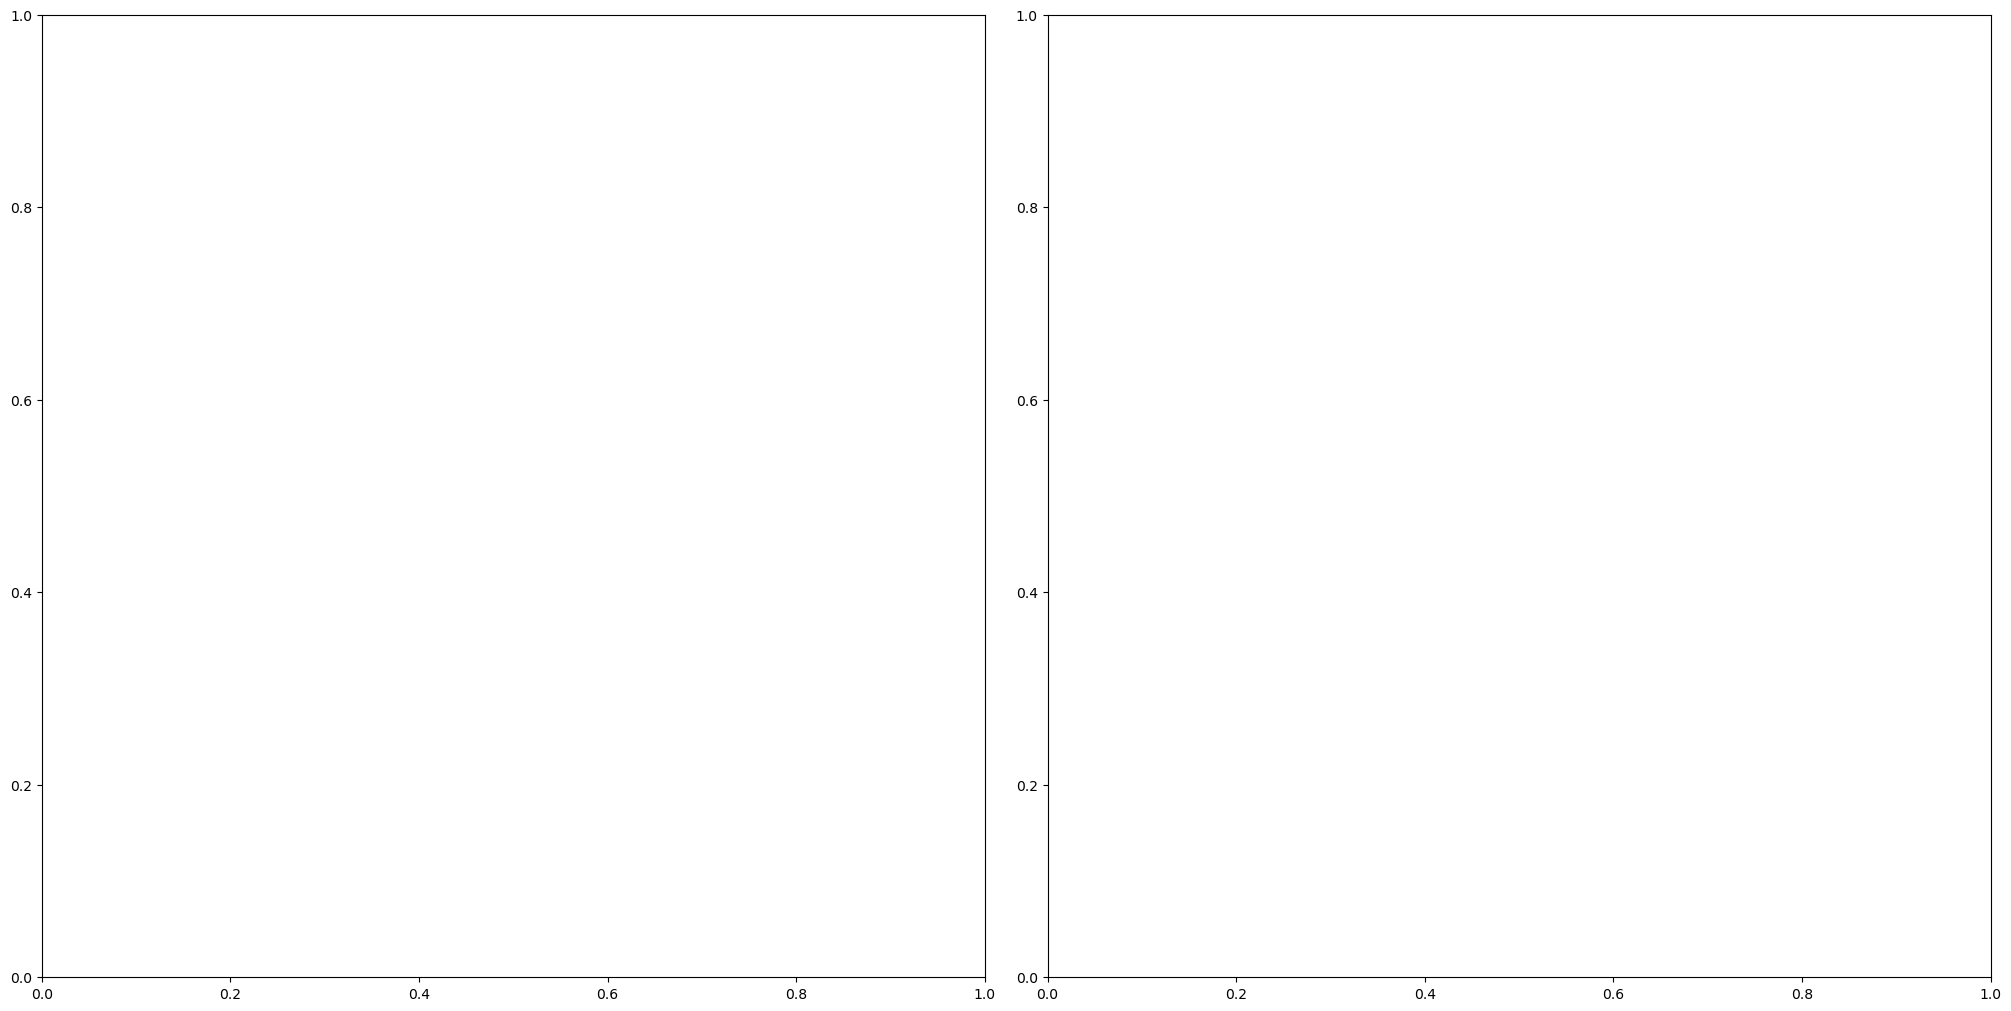

4 of 489 peaks below limit
 0.8179959100204499 % are below 230
The lowest peak is: 213


In [25]:
img_id = 'MF_MaxIP_3ch_2_000_230623_544_84_F_XY4'
plot_limit = 230
plot_min_under_threshold(img_id, plot_limit)


In [16]:
def plot_masks(img_id):
    # Load GT mask and original image
    img = cv2.imread(f'../data/images_fullsize/images/{img_id}.tif', cv2.IMREAD_UNCHANGED)
    img = np.array(img)
    print(f'min img: {img.min()}')
    masks_uint8 = cv2.imread(f'../data/images_fullsize/masks/{img_id}_masks.png', cv2.IMREAD_UNCHANGED)
    masks = masks_uint8/255

    # Get mask count
    ann_map, num_features = label(masks)
    max_values = []
    plt.figure()
    plt.imshow(img)
    for value in range(1,num_features+1):
        coords = np.argwhere(ann_map == value)
        spot = img[coords[:, 1], coords[:, 0]]
        spot_max = spot.max()
        plt.scatter(coords[:, 1], coords[:, 0], c='r', s=1)
        # fig.colorbar(im1, ax=axes[1],location='right')

            
            
        if len(coords)>4:
            # result = np.all(masks[coords[:, 0], coords[:, 1]] == 1) just to check that all pixels belong to mask
            
            # spot = img[coords[:, 1], coords[:, 0]]
            max_values.append(spot_max)
        else:
            print(len(coords))
            print(spot.max())

    plt.show()

    plt.hist(max_values, bins=len(max_values), edgecolor='black')
    print(np.array(max_values).min())
    plt.show()



Text(0, 0.5, 'y')

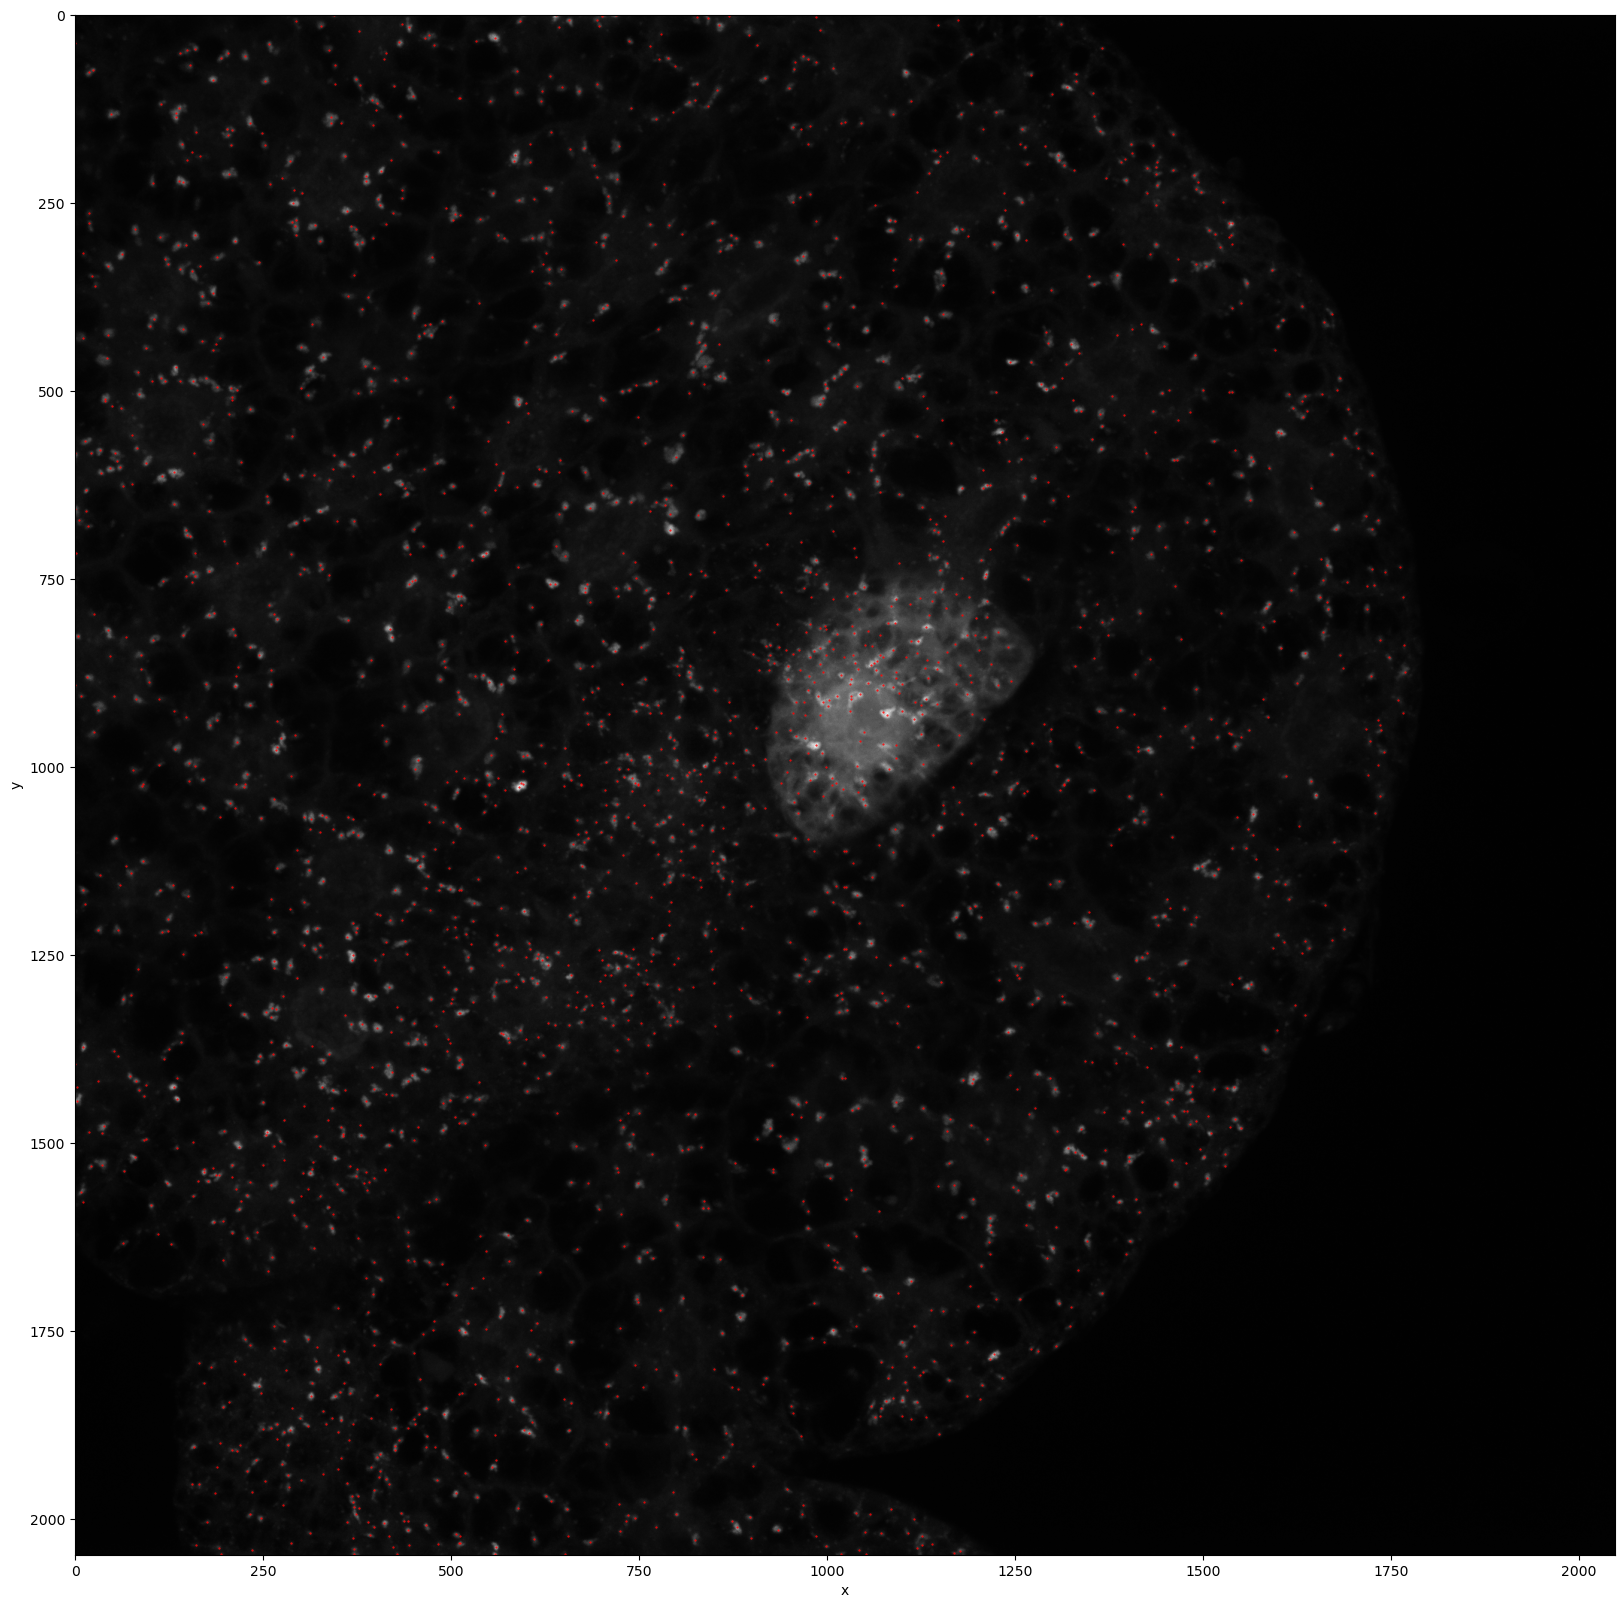

In [38]:
# Show image in bigger size to better see masks

img_id = 'MF_MaxIP_3ch_2_000_230623_544_84_R1h_XY5'
min_elevation =500
min_prominence = 180
# Load results and GT mask
# df = pd.read_csv(f'results/{img_id}.txt', delimiter=',')
df = pd.read_csv(f'results/results_fullsize/{img_id}.txt', delimiter=',')

# masks_uint8 = cv2.imread(f'masks/{img_id}_masks.png', cv2.IMREAD_UNCHANGED)
img = cv2.imread(f'data/images_fullsize/images/{img_id}.tif', cv2.IMREAD_UNCHANGED)
img = np.array(img)
masks_uint8 = cv2.imread(f'data/images_fullsize/masks/{img_id}_masks.png', cv2.IMREAD_UNCHANGED)
masks = masks_uint8/255

# filter low elevation
filtered_df = df[df['elevation'] >= min_elevation]
filtered_df = filtered_df[filtered_df['prominence'] >= min_prominence]

df = filtered_df.copy()
# df[['x', 'y']] = df[['x', 'y']].astype(int)

df['pixel_value'] = 0

for index, row in df.iterrows():
    img_value = img[int(row['y']), int(row['x'])]
    # img_value = img[row['x'], row['y']]
    df.at[index, 'pixel_value'] = img_value

fig1 = plt.figure(figsize=(20,20))
plt.imshow(img, cmap='gray')
for index, row in df.iterrows():
    plt.plot(row['x'], row['y'], marker='.', markersize=1, c='r')
plt.xlabel('x')
plt.ylabel('y')

In [39]:
# Show dataframe. NOTE: eleveation and pixelvalue is not the same

df

,x,y,elevation,key_s_lat,key_s_long,prominence,pixel_value
0,344.0128,0.0000,695.0,-0.0010,0.6513,440.0,471
2,293.9904,7.9872,639.0,-0.0098,0.5928,386.0,383
3,434.9952,11.9808,685.0,-0.0224,0.8544,244.0,392
4,327.0144,13.9776,1029.0,-0.0029,0.6914,775.0,601
6,444.0064,15.9744,1932.0,-0.1650,0.7489,1693.0,1019
...,...,...,...,...,...,...,...
3593,1120.0000,2038.0160,837.0,-0.9736,0.1904,275.0,546
3594,1042.9952,2040.9856,679.0,-0.9258,0.0479,426.0,400
3596,1176.9856,2042.0096,1358.0,-0.7627,0.0185,1236.0,770
3598,1168.9984,2044.9792,920.0,-0.9940,0.2918,221.0,513


In [40]:
filtered_df = df[df['pixel_value'] <= 300]

filtered_df

,x,y,elevation,key_s_lat,key_s_long,prominence,pixel_value
41,344.9856,90.9824,501.0,-0.0780,0.5711,266.0,266
55,399.9744,126.0032,555.0,-0.2392,0.7842,203.0,274
144,11.0080,316.9792,520.0,-0.6396,0.0575,269.0,260
237,984.9856,1.9968,504.0,-0.0107,0.9248,249.0,288
256,532.9920,33.9968,626.0,-0.0625,0.0665,361.0,262
...,...,...,...,...,...,...,...
3450,1146.9824,1556.9920,537.0,-0.0400,0.2646,265.0,294
3452,1031.9872,1562.0096,558.0,-0.0574,0.0176,243.0,300
3562,1202.9952,1840.9984,578.0,-0.5810,0.3427,317.0,262
3572,1131.9808,1865.0112,515.0,-0.6299,0.2040,241.0,258
